# Phase4 Project

## Business Objective

To help Acme Online analyze customer tweets from their Twitter page about Apple and Google products. The result of this analysis will be used to find out ways to increase customer satisfaction, why certain products are more successful than others, are there customers contemplating switching from Apple to Google or vice-versa etc.

## Methodology

We will be using a database that consists of approximately 9000 tweets about Apple and Google products purchased from Acme Online own store. NLP modelling method will be employed to analyze the tweet and classify it as 'positive', 'negative' or 'neutral'. The resulting classification should help us understand which company's product an services are successful and hopefully give us insight as to why as well.

# Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk import FreqDist
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords',quiet=True)
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score,accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import the csv file
df = pd.read_csv('tweets.csv',encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# renaming columns for better readability
df.columns=['tweet_text','product_service','emotion']
df.head()

,tweet_text,product_service,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       9092 non-null   object
 1   product_service  3291 non-null   object
 2   emotion          9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.head()

,tweet_text,product_service,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


We can see that the `product_service` column is missing more than 50% of the data

In [6]:
# looking at the emotion column
df['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

We can see that we have a very unbalanced dataset. Let's explore the data further

In [7]:
#slicing the 'no emotion....' sentiment
df_no_emotion = df[df['emotion'] == 'No emotion toward brand or product']
df_no_emotion

,tweet_text,product_service,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [8]:
df_no_emotion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5389 entries, 5 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       5388 non-null   object
 1   product_service  91 non-null     object
 2   emotion          5389 non-null   object
dtypes: object(3)
memory usage: 168.4+ KB


We can infer that there is no product or service listed against tweets that are as classified as 'No emotion towards brand or product'. Sine it does not add any value for our analysis, we can delete this class entirely.

In [9]:
#removing the 'no mention...' classifier from the df
df = df[df['emotion'] != 'No emotion toward brand or product']
df['emotion'].value_counts()

Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: emotion, dtype: int64

In [10]:
#creating target values for emotion for the analysis
new_map  = {'Positive emotion':1,
          'Negative emotion':0,
          "I can't tell":2}

df['target'] = df['emotion'].map(new_map)

In [11]:
df['target'].value_counts()

1    2978
0     570
2     156
Name: target, dtype: int64

In [12]:
#checking for null values
df.isna().sum()

tweet_text           0
product_service    504
emotion              0
target               0
dtype: int64

Looks like 'product_service' has 504 null values

In [13]:
#looking at the null values
df[df['product_service'].isnull()]

,tweet_text,product_service,emotion,target
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive emotion,1
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion,0
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative emotion,0
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell,2
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell,2
...,...,...,...,...
9043,Hey is anyone doing #sxsw signing up for the g...,NaN,Negative emotion,0
9049,@mention you can buy my used iPad and I'll pic...,NaN,Positive emotion,1
9052,@mention You could buy a new iPad 2 tmrw at th...,NaN,Positive emotion,1
9054,"Guys, if you ever plan on attending #SXSW, you...",NaN,Positive emotion,1


This is similar to what we saw earlier. Although now we have emotional classifiers, it looks like the tweets are not referring to a product or service. Let's keep these tweets for our analysis. They could help better train the model.

We have now have a dataframe that we can use for modelling. We can begin pre-processing the data

## Preprocessing

### Removing capitalization, punctuations and tokenizing

In [14]:
# Removing capiltalization
df['tweet_text'] = df['tweet_text'].str.lower()

#removing punctuations
#use the default pattern in sklearn
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

#applying the tokenizer to the df
df['text_token'] = df['tweet_text'].apply(tokenizer.tokenize)
df.head(10)

,tweet_text,product_service,emotion,target,text_token
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,0,"[wesley83, have, 3g, iphone, after, hrs, tweet..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,1,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,1,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,"[sxsw, hope, this, year, festival, isn, as, cr..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,1,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."
7,"#sxsw is just starting, #ctia is around the co...",Android,Positive emotion,1,"[sxsw, is, just, starting, ctia, is, around, t..."
8,beautifully smart and simple idea rt @madebyma...,iPad or iPhone App,Positive emotion,1,"[beautifully, smart, and, simple, idea, rt, ma..."
9,counting down the days to #sxsw plus strong ca...,Apple,Positive emotion,1,"[counting, down, the, days, to, sxsw, plus, st..."
10,excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,1,"[excited, to, meet, the, samsungmobileus, at, ..."
11,find &amp; start impromptu parties at #sxsw wi...,Android App,Positive emotion,1,"[find, amp, start, impromptu, parties, at, sxs..."


### FreqDist

In [15]:
#visualzing the freq distribution of all the words in the text_token column
from nltk import FreqDist

#since FreqDist can only work with a list of words, we need take all the words from the text_token column
# and export it into a list. We can do this using the 'explode' method

freq_dist = FreqDist(df['text_token'].explode())
freq_dist

FreqDist({'sxsw': 3891, 'mention': 2611, 'the': 1982, 'to': 1467, 'link': 1367, 'ipad': 1264, 'at': 1217, 'rt': 1109, 'apple': 1093, 'for': 1070, ...})

In [16]:
#defining a function to plot the top_25 most occuring words

def plot_freq_dist(words):
    freq_dist = FreqDist(df[words].explode())
    # listing out the top 25 most occuring words and ther respective counts
    top_25 = list(zip(*freq_dist.most_common(25)))

    #creating a plot of the top_25 words
    fig,ax=plt.subplots(figsize=(7,7))
    ax.bar(top_25[0],top_25[1])
    ax.set_title('Top 25 most occurring words')
    ax.tick_params(axis='x', rotation=90)

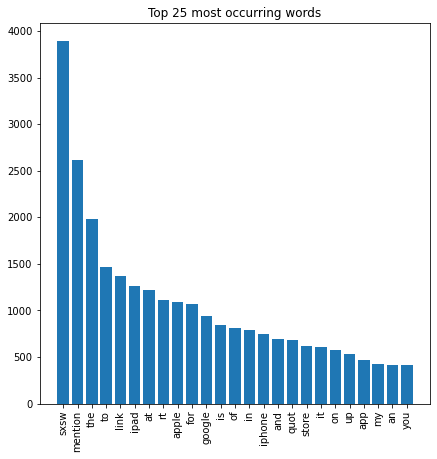

In [17]:
plot_freq_dist('text_token')

From the graph, we can see that words like (at,for,is,to) etc. occur quite frequently. Since these 'stopwords' add no semantic value to the text we can filter them out from the data.

### Removing Stopwords

In [18]:
#removing stopwords
#importing the default list of stopwords for the englosh language
stopwords_list = stopwords.words('english')

#creating a function to remove stopwords
def remove_stopwords(text_token):
    
    tokens_without_stopwords = [token for token in text_token if token not in stopwords_list]
    return tokens_without_stopwords

In [19]:
#applying the function to the text_token column in the df
df['tokens_without_stopwords'] = df['text_token'].apply(remove_stopwords)
df.head()

,tweet_text,product_service,emotion,target,text_token,tokens_without_stopwords
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,0,"[wesley83, have, 3g, iphone, after, hrs, tweet...","[wesley83, 3g, iphone, hrs, tweeting, rise_aus..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,1,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,1,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,"[sxsw, hope, this, year, festival, isn, as, cr...","[sxsw, hope, year, festival, crashy, year, iph..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,1,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


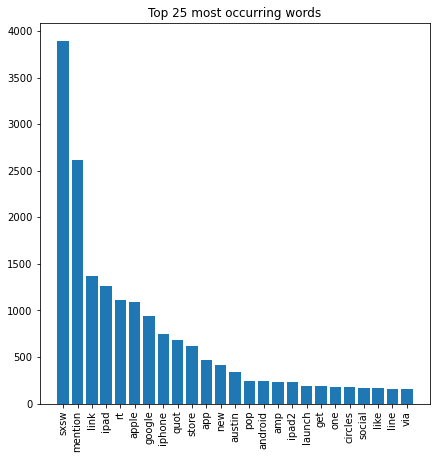

In [20]:
#using the plot_freq_dist to vizualize the frequencies after removing the stopwords
plot_freq_dist('tokens_without_stopwords')

# Creating train and test sets

In [21]:
#splitting the into train and test sets for the analysis
#creating X and y
X = df['tokens_without_stopwords']
y = df['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

# CountVectorizer

In [22]:
"""
CV only runs on strings. It does some pre-processing and tokenizing before vectorizing.
Since we have already pre-processed our data, we need to tell CV to ignore these steps.
The default parameters for the preprocssor and tokenzier is None, even though some preprocessing and tokenzing take place
when you fit CV onto the data. Hence,to circumvent this, you just create a dummy function that returns just the input and pass
that into the preprocessing and tokenizing parameters.

"""
def dummy(doc):
    return doc

In [23]:
#instantiate the CountVectorizer
vect = CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)

#fit transform on the train set
X_train_vect = vect.fit_transform(X_train)
X_train_vect

<2778x5258 sparse matrix of type '<class 'numpy.int64'>'
	with 32407 stored elements in Compressed Sparse Row format>

In [24]:
"""
o/p of vectorized data is a sparse matrix. To view the matrix, it has to be converted into a df.
You do that by first transforming it into an array and then into a df.
The o/p of the vectorizer is the count of how much each token appears in all the documents

"""
#converting the sparse matrix into an array to be able to create a df
X_train_vect_array = X_train_vect.toarray()

#create a df of the vectorized train set
X_train_vect_df = pd.DataFrame(data=X_train_vect_array,columns=vect.get_feature_names())
X_train_vect_df.head()


,000,02,03,0310apple,08,10,100,100s,100tc,101,...,ûïfoursquare,ûïmute,ûïspecials,ûïthe,ûò,ûòand,ûó,ûójust,ûólewis,ûóthe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#transforming the X_test
X_test_vect = vect.transform(X_test)
X_test_vect

<926x5258 sparse matrix of type '<class 'numpy.int64'>'
	with 9893 stored elements in Compressed Sparse Row format>

In [26]:
#converting the sparse matrix into an array to be able to create a df
X_test_vect_array = X_test_vect.toarray()

#create a df of the vectorized train set
X_test_vect_df = pd.DataFrame(data=X_test_vect_array,columns=vect.get_feature_names())
X_test_vect_df.head()

,000,02,03,0310apple,08,10,100,100s,100tc,101,...,ûïfoursquare,ûïmute,ûïspecials,ûïthe,ûò,ûòand,ûó,ûójust,ûólewis,ûóthe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#define a function to get the f1_score of the model. use the values to build a vizualization of the scores
# all the baseline models.
scores = []
def get_f1_score(y_test,predictions):
    f1_score_model = round(f1_score(y_test,predictions,average='macro'),3)
    scores.append(f1_score_model)
    return f1_score_model

## Baseline Logistic Regression with CountVectorizer

In [61]:
lr_pipe = Pipeline([('vectorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                       ('model', LogisticRegression())
                     ])

lr_pipe.fit(X_train,y_train)
predictions=lr_pipe.predict(X_test)

labels = ['Negative emotion', 'Positive emotion', "I can't tell"]

print(classification_report(y_test,predictions))

#get f1_score
f1_LR = get_f1_score(y_test,predictions)

              precision    recall  f1-score   support

           0       0.65      0.40      0.49       136
           1       0.88      0.97      0.92       756
           2       0.22      0.06      0.09        34

    accuracy                           0.85       926
   macro avg       0.58      0.47      0.50       926
weighted avg       0.82      0.85      0.83       926



## Baseline Naive Bayes Model with CountVectorizer

In [29]:
nb_pipe = Pipeline([('vectorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                       ('model', MultinomialNB())
                     ])

nb_pipe.fit(X_train,y_train)
predictions=nb_pipe.predict(X_test)

print(classification_report(y_test,predictions,target_names=labels))

#get f1 score
f1_NB = get_f1_score(y_test,predictions)

                  precision    recall  f1-score   support

Negative emotion       0.71      0.30      0.42       136
Positive emotion       0.86      0.98      0.92       756
    I can't tell       0.00      0.00      0.00        34

        accuracy                           0.85       926
       macro avg       0.52      0.43      0.45       926
    weighted avg       0.80      0.85      0.81       926



## Baseline Random Forest with CountVectorizer

In [30]:
rf_pipe = Pipeline([('vectorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                       ('model', RandomForestClassifier())
                     ])

rf_pipe.fit(X_train,y_train)
predictions=rf_pipe.predict(X_test)

print(classification_report(y_test,predictions,target_names=labels))

#get f1 score
f1_RF = get_f1_score(y_test,predictions)

                  precision    recall  f1-score   support

Negative emotion       0.85      0.29      0.43       136
Positive emotion       0.85      0.99      0.92       756
    I can't tell       0.33      0.03      0.05        34

        accuracy                           0.85       926
       macro avg       0.68      0.44      0.47       926
    weighted avg       0.83      0.85      0.81       926



## f1_scores of baseline models

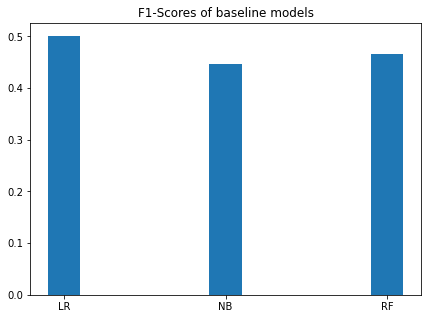

In [31]:
#viewing the f1-scores

fig,ax = plt.subplots(figsize=(7,5))
ax.bar(x=['LR','NB','RF'],height=scores,width=0.2);
ax.set_title('F1-Scores of baseline models');

## CountVectorizer (min_df,max_df) tuning with Logistic Regression

min_df = 2, max_df = 25, f1_score=0.459
min_df = 2, max_df = 26, f1_score=0.463
min_df = 2, max_df = 27, f1_score=0.459
min_df = 2, max_df = 28, f1_score=0.46
min_df = 2, max_df = 29, f1_score=0.462
min_df = 3, max_df = 25, f1_score=0.428
min_df = 3, max_df = 26, f1_score=0.435
min_df = 3, max_df = 27, f1_score=0.434
min_df = 3, max_df = 28, f1_score=0.434
min_df = 3, max_df = 29, f1_score=0.435
min_df = 4, max_df = 25, f1_score=0.417
min_df = 4, max_df = 26, f1_score=0.426
min_df = 4, max_df = 27, f1_score=0.422
min_df = 4, max_df = 28, f1_score=0.423
min_df = 4, max_df = 29, f1_score=0.423
min_df = 5, max_df = 25, f1_score=0.418
min_df = 5, max_df = 26, f1_score=0.419
min_df = 5, max_df = 27, f1_score=0.417
min_df = 5, max_df = 28, f1_score=0.417
min_df = 5, max_df = 29, f1_score=0.42
min_df = 6, max_df = 25, f1_score=0.418
min_df = 6, max_df = 26, f1_score=0.424
min_df = 6, max_df = 27, f1_score=0.424
min_df = 6, max_df = 28, f1_score=0.424
min_df = 6, max_df = 29, f1_score=0.423


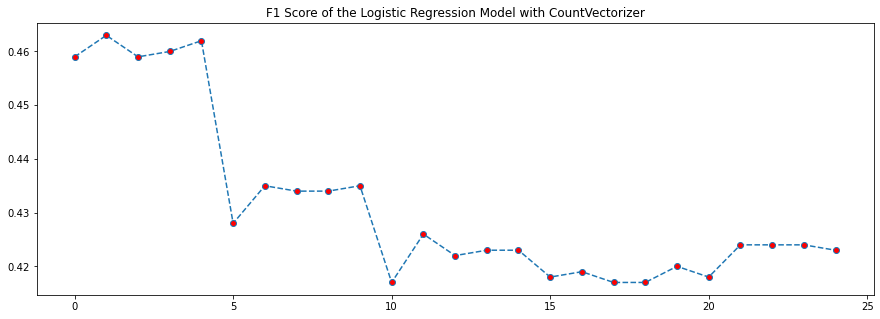

In [32]:
# setting a range for min_df and max_df
min_df = np.arange(2,7,1) # words than appear less than the min_df value in all docs will be eliminated
max_df = np.arange(25,30,1) # words than appear more than the max_df value in all docs will be eliminated

#initiating lists to use for plotting
f_score = []
min_value=[]
max_value=[]

#setting up the loop for min_df and max_df values
for i in min_df:
    for j in max_df:
        min_value.append(i)
        max_value.append(j)
        
        #instantiate pipeline
        lr_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words=stopwords_list,min_df=i,max_df=j,preprocessor=dummy,tokenizer=dummy)),
                       ('model', LogisticRegression()) 
                       ])
        lr_pipe.fit(X_train,y_train)
        predictions = lr_pipe.predict(X_test)
        
        #getting f1 score
        score = get_f1_score(y_test,predictions)
        f_score.append(score)
        print(f'min_df = {i}, max_df = {j}, f1_score={score}')

#visualizing the accuracy score for the different combinations
d = list(zip(min_value,max_value))
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(f_score,marker='o',markerfacecolor='r',ls='--');
# ax.set_xticklabels(d);
ax.set_title('F1 Score of the Logistic Regression Model with CountVectorizer');

## Stemming

In [33]:
#initializing the stemmer
ps=PorterStemmer()

#creating a function to tokenize and stem the tokens
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [ps.stem(token) for token in tokens]

In [34]:
#creating a new column in the df for the stemmed tokens. This will now be used to analysis
df['stemmed_tokens'] = df['tweet_text'].apply(stem_and_tokenize)

# removing stopwords from the stemmed tokens
df['stemmed_tokens'] = df['stemmed_tokens'].apply(remove_stopwords)
df.head()

,tweet_text,product_service,emotion,target,text_token,tokens_without_stopwords,stemmed_tokens
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,0,"[wesley83, have, 3g, iphone, after, hrs, tweet...","[wesley83, 3g, iphone, hrs, tweeting, rise_aus...","[wesley83, 3g, iphon, hr, tweet, rise_austin, ..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,1,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipad, iphon...","[jessede, know, fludapp, awesom, ipad, iphon, ..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,1,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,"[sxsw, hope, this, year, festival, isn, as, cr...","[sxsw, hope, year, festival, crashy, year, iph...","[sxsw, hope, thi, year, festiv, crashi, thi, y..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,1,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ...","[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


In [35]:
#changing the train and test sets 
#splitting the into train and test sets for the analysis
#creating X and y
X = df['stemmed_tokens']
y = df['target']

X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X,y,random_state=42)

## Baseline Logistic Regression with stemmed_tokens

In [36]:
lr_pipe_2 = Pipeline([('vectorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                       ('model', LogisticRegression())
                     ])

lr_pipe_2.fit(X_train_2,y_train_2)
predictions_2=lr_pipe_2.predict(X_test_2)

print(classification_report(y_test_2,predictions_2,target_names=labels))

f1_LR_stem = get_f1_score(y_test_2,predictions_2)

                  precision    recall  f1-score   support

Negative emotion       0.63      0.42      0.50       136
Positive emotion       0.88      0.96      0.92       756
    I can't tell       0.25      0.06      0.10        34

        accuracy                           0.85       926
       macro avg       0.59      0.48      0.51       926
    weighted avg       0.82      0.85      0.83       926



## Baseline Naive Bayes with stemmed_tokens

In [37]:
nb_pipe_2 = Pipeline([('vectorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                       ('model', MultinomialNB())
                     ])

nb_pipe_2.fit(X_train_2,y_train_2)
predictions_2=nb_pipe_2.predict(X_test_2)

print(classification_report(y_test_2,predictions_2,target_names=labels))

f1_NB_stem = get_f1_score(y_test_2,predictions_2)

                  precision    recall  f1-score   support

Negative emotion       0.68      0.32      0.44       136
Positive emotion       0.86      0.98      0.92       756
    I can't tell       0.00      0.00      0.00        34

        accuracy                           0.85       926
       macro avg       0.51      0.43      0.45       926
    weighted avg       0.80      0.85      0.81       926



## Baseline Random Forest with stemmed_tokens

In [38]:
rf_pipe_2 = Pipeline([('vectorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                       ('model', RandomForestClassifier())
                     ])

rf_pipe_2.fit(X_train_2,y_train_2)
predictions_2=rf_pipe_2.predict(X_test_2)

print(classification_report(y_test_2,predictions_2,target_names=labels))

f1_RF_stem = get_f1_score(y_test_2,predictions_2)

                  precision    recall  f1-score   support

Negative emotion       0.83      0.29      0.43       136
Positive emotion       0.86      0.99      0.92       756
    I can't tell       0.50      0.03      0.06        34

        accuracy                           0.85       926
       macro avg       0.73      0.44      0.47       926
    weighted avg       0.84      0.85      0.82       926



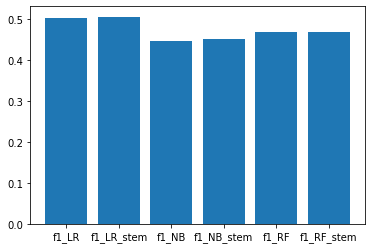

In [64]:
fig,ax=plt.subplots()
ax.bar(x=['f1_LR','f1_LR_stem','f1_NB','f1_NB_stem','f1_RF','f1_RF_stem'],
       height=[f1_LR,f1_LR_stem,f1_NB,f1_NB_stem,f1_RF,f1_RF_stem]);

# TF-IDF Vectorizer

In [66]:
#instantiate 
tfidf = TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)

#fit and transform train set
X_train_tf = tfidf.fit_transform(X_train_2)

#convert into a df
X_train_tf_array = X_train_tf.toarray()
X_train_tf_df = pd.DataFrame(data=X_train_tf_array,columns=tfidf.get_feature_names())
X_train_tf_df.head()

,000,02,03,0310appl,08,10,100,100tc,101,106,...,ûïfoursquar,ûïmute,ûïspecial,ûïthe,ûò,ûòand,ûó,ûójust,ûólewi,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
#transforming the X_test
X_test_tf = tfidf.transform(X_test_2)
X_test_tf

<926x4244 sparse matrix of type '<class 'numpy.float64'>'
	with 10340 stored elements in Compressed Sparse Row format>

## Logistic Regression with TF-IDF Vectorizer

In [65]:
logreg_tf = Pipeline([('vectorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                     ('model', LogisticRegression())
                     ])
logreg_tf.fit(X_train_2,y_train_2)
predictions_3 = logreg_tf.predict(X_test_2)

print(classification_report(y_test_2,predictions_3,target_names=labels))
# plot_confusion_matrix(logreg_tf,X_test,y_test,display_labels=labels,xticks_rotation='vertical');

                  precision    recall  f1-score   support

Negative emotion       0.82      0.23      0.36       136
Positive emotion       0.85      0.99      0.91       756
    I can't tell       0.00      0.00      0.00        34

        accuracy                           0.84       926
       macro avg       0.55      0.41      0.42       926
    weighted avg       0.81      0.84      0.80       926



In [ ]:
z